In [1]:
import numpy as np
from PIL import Image
# import imageio
import matplotlib.pyplot as plt
from keras import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Dropout, concatenate, Conv2DTranspose, Flatten
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import os
import cv2
import glob
import pandas as pd

In [2]:
def read_image(item, mask):
  if mask==True:
    image=cv2.imread(item, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (128,128))
    # 
    new_image=np.zeros((128,128,9))
    for i in range(9):
      if i>0:
        array = np.where(image==i)
        for index,tuple in enumerate(array[0]):
          new_image[array[0][index]][array[1][index]][i]=1
    return new_image
    # return image
  else:
    image = cv2.imread(item, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (128, 128))
    rgb=image[:,:,:-1]
    rgb_avg=np.sum(rgb, axis=-1)
    plt.imshow(rgb_avg, cmap="gist_gray")
    thermal = image[:,:,-1]
    new_img=np.zeros((128,128,2))
    new_img[:,:,0] = (rgb_avg-rgb_avg.min())/(rgb_avg.max()-rgb_avg.min())
    new_img[:,:,1] = (thermal-thermal.min())/(thermal.max()-thermal.min())

    # thermal images
    # return image[:,:,-1:]

    # # rgb+thermal
    return new_img

In [3]:
# remove images that don't have a mask
img_dir = sorted(os.listdir("ir_seg_dataset/images/"))
label_dir = sorted(os.listdir("ir_seg_dataset/labels/"))
new_img_dir=[]
for item in img_dir:
    # print("analyzing: ", item)
    if item in label_dir:
        new_img_dir.append(item)
# print(len(new_img_dir))

In [4]:
day_img = []
day_mask = []
n_count=0
d_count=0
for item in new_img_dir:
    if item[-5]=='D':
        # print(item, " contains N") 
        day_img.append(item)
        day_mask.append(item)
        d_count+=1
    else:
        # print(item, " contains D")
        n_count+=1
print(n_count, d_count, n_count+d_count)

749 820 1569


100%|██████████| 820/820 [00:08<00:00, 91.80it/s]


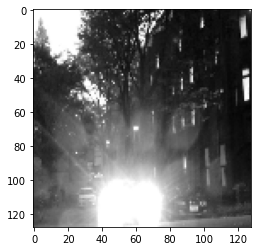

In [5]:
# img_dir = sorted(glob.glob("ir_seg_dataset/images/*.png"))
# mask_dir = sorted(glob.glob("ir_seg_dataset/labels/*.png"))
# print(mask_dir)
all_images = []
all_masks = []
for item in tqdm(day_img):
    image = read_image("ir_seg_dataset/images/"+item, mask=False)
    # image = read_image("ir_seg_dataset/images/"+item)
    all_images.append(image)

In [6]:
for item in tqdm(day_mask):
    mask = read_image("ir_seg_dataset/labels/"+item, mask=True)
    # mask = read_image(item)
    all_masks.append(mask)
    # print(item)

100%|██████████| 820/820 [00:02<00:00, 401.28it/s]


In [7]:
print(all_images[0].shape)
x_data = np.stack(all_images, axis=0)
y_data = np.stack(all_masks, axis=0).astype(int)

(128, 128, 2)


In [8]:
print(x_data.min(), x_data.max())
print(y_data[0].min(), y_data[0].max())
print(x_data[0].min(), x_data[0].max())

0.0 1.0
0 1
0.0 1.0


In [9]:
# print object shapes
print(x_data.shape)
print(y_data.shape)

(820, 128, 128, 2)
(820, 128, 128, 9)


711


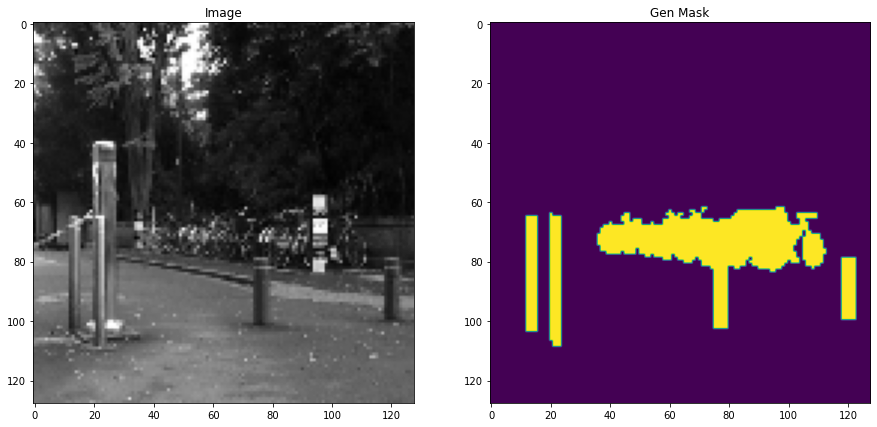

In [ ]:
# show exemplary mask
fig = plt.figure(figsize=(15, 10))
rows = 1
columns =2
i=np.random.randint(len(day_img))
# i=449
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(x_data[i][:,:,0], cmap="gist_gray")
plt.title("Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
# plt.imshow(y_data[i][:,:,1])
avg_img = np.sum(y_data[i], axis=2)
plt.imshow(avg_img)
plt.title("Gen Mask")

print(i)

In [10]:
all_indices = np.arange(0, len(x_data))
np.random.shuffle(all_indices)
TEST_FRAC = 0.1
test_indices = all_indices[0:int(len(x_data)*TEST_FRAC)]
train_indices = all_indices[int(len(x_data)*TEST_FRAC):]
x_train = x_data[train_indices]
y_train = y_data[train_indices]
x_test = x_data[test_indices]
y_test = y_data[test_indices]

In [11]:
#clear RAM
all_images=[]
all_masks=[]
x_data=[]
y_data=[]
all_indices=[]
test_indices=[]
train_indices=[]

In [12]:
class NonNegative(tf.keras.constraints.Constraint):
    def __call__(self, w):
        w=w * tf.cast(tf.math.greater_equal(w, 0.), w.dtype)
        return tf.math.divide(w,tf.math.reduce_sum(w))

class Illumination(tf.keras.layers.Layer):
    def __init__(self, is_train=False, **kwargs):
        super(Illumination, self).__init__()
        self.is_train=is_train

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'is_train': self.is_train,
        })
        return config

    def build(self, input_shape):
        self.filt=1
        self.size=(1,1)
        self.stride=1
        self.pad="same"
        self.bias=False
        self.initializer = tf.keras.initializers.Ones()
        self.conv2d=tf.keras.layers.Conv2D(filters=self.filt, kernel_size=self.size, strides=self.stride, padding=self.pad, 
                                           use_bias=self.bias, kernel_initializer=self.initializer, kernel_constraint=NonNegative())
    
    def call(self, inputs):
        return self.conv2d(inputs)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, MaxPooling2D, BatchNormalization

def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32, dropout_prob=0.3):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input])
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    if dropout_prob>0:
        conv = Dropout(dropout_prob)(conv)
    return conv

In [ ]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=2, illumination=False):
    inputs = Input(input_size)
    if illumination==True:
        illu=Illumination(is_train=True)(inputs)
    else:
        illu=inputs

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(illu, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.2, max_pooling=True)

    #bottleneck
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0, max_pooling=False) 

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8, dropout_prob=0)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4, dropout_prob=0)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2, dropout_prob=0)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters, dropout_prob=0.2)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation='sigmoid')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [13]:
def dice_coefficient(y_true, y_pred):
    intersection = 2 * tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred)
    return (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

In [ ]:
# import keras.backend as K
# import math
# def dice_bce_loss(y_true, y_pred, smooth=1e-6):
#     y_true = tf.cast(y_true, tf.float32)
#     # y_pred = tf.math.sigmoid(y_pred)

#     numerator = 2 * tf.reduce_sum(y_true * y_pred) + smooth
#     denominator = tf.reduce_sum(y_true + y_pred) + smooth
#     dice = 1-(numerator / denominator)
#     # bce = tf.keras.metrics.binary_crossentropy(y_true, y_pred)

#     return K.mean(dice)

In [14]:
unet = UNetCompiled(input_size=(128,128,2), n_filters=32, n_classes=9, illumination=True)
unet.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[dice_coefficient])
unet.summary()


NameError: name 'UNetCompiled' is not defined

In [ ]:
unet.layers[1].get_weights()

[array([[[[1.],
          [1.]]]], dtype=float32)]

In [ ]:
# bad_pred = unet.predict(x_test[0:1])[0]

In [15]:
checkpoint_path = "training_models/physical_layer_day/my_best_model_day_testing.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_dice_coefficient", patience=40, verbose=0, mode='max', restore_best_weights='True')
mcp_save = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_dice_coefficient", mode='max')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_dice_coefficient", factor=0.1, patience=25, verbose=1, mode='max')

history = unet.fit(x_train, y_train, epochs=200, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(x_test, y_test))

NameError: name 'unet' is not defined

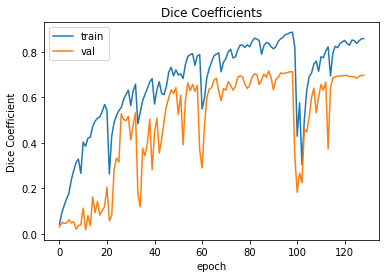

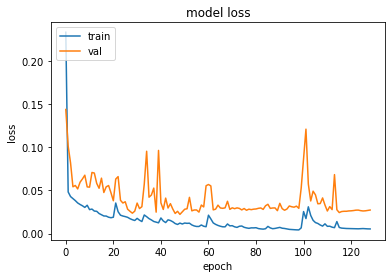

In [ ]:
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Dice Coefficients')
plt.ylabel('Dice Coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
dependencies = {
    'dice_coefficient': dice_coefficient,
    'Illumination': Illumination
}
checkpoint_path = "training_models/physical_layer_day/my_best_model_day_testing.hdf5"

unet=keras.models.load_model(checkpoint_path, custom_objects=dependencies, )

val_loss, val_dice_coefficient = unet.evaluate(x_test, y_test, verbose=2)
print("Restored model, val_dice_coefficient: {:5.2f}%".format(100 * val_dice_coefficient))

3/3 - 20s - loss: 0.0082 - dice_coefficient: 0.8380
Restored model, val_dice_coefficient: 83.80%


(128, 128, 9)


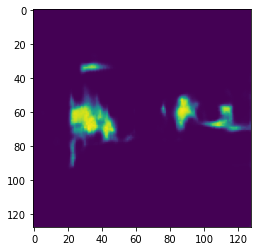

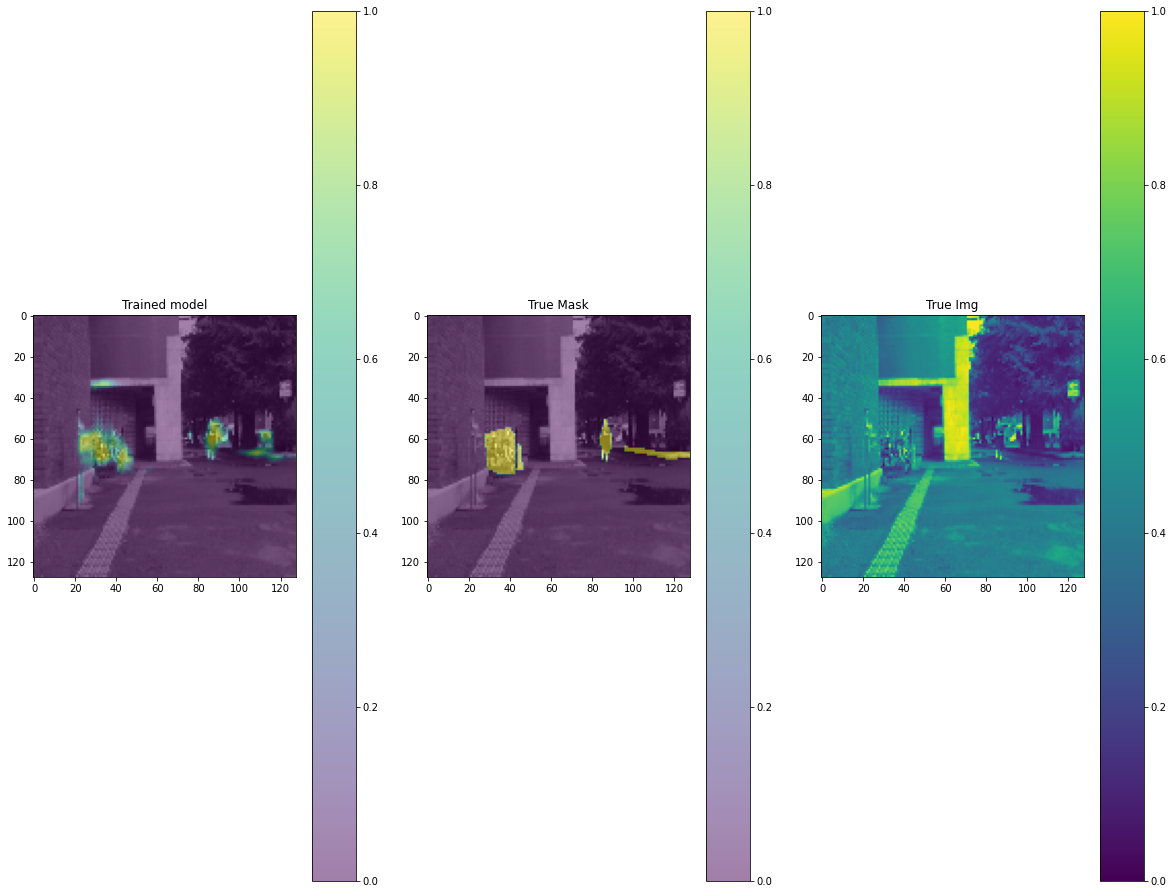

In [ ]:
i=50
j=i+1
img= x_test[i:j]
pred_y = unet.predict(img)[0]
print(pred_y.shape)
# plt.imshow(pred_y[:,:,6])
# pred_mask = tf.argmax(pred_y, axis=-1)
# pred_mask = pred_mask[..., tf.newaxis]
# good_pred=pred_mask
avg_img = np.sum(pred_y, axis=2)

plt.imshow(avg_img)


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 16))
# axs[0].set_title("Untrained model")
# axs[0].imshow(x_test[i], cmap=plt.cm.gray)
# im = axs[0].imshow(bad_pred[:,:,0], alpha=0.5, vmin=0, vmax=1)
# plt.colorbar(im, ax=axs[0])

axs[0].set_title("Trained model")
axs[0].imshow(x_test[i][:,:,0], cmap=plt.cm.gray)
im = axs[0].imshow(avg_img, alpha=0.5, vmin=0, vmax=1)
plt.colorbar(im, ax=axs[0])

true_mask=np.sum(y_test[i:j][0], axis=2)
axs[1].set_title("True Mask")
axs[1].imshow(x_test[i][:,:,0], cmap=plt.cm.gray)
im = axs[1].imshow(true_mask, alpha=0.5, vmin=0, vmax=1)
plt.colorbar(im, ax=axs[1])

axs[2].set_title("True Img")
axs[2].imshow(x_test[i][:,:,0], cmap=plt.cm.gray)
im = axs[2].imshow(x_test[i:j][0][:,:,0])
plt.colorbar(im, ax=axs[2])

In [17]:
unet.layers[1].get_weights()

[array([[[[0.563813  ],
          [0.43618706]]]], dtype=float32)]

(128, 128)


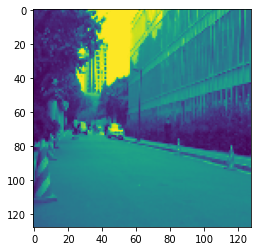

In [ ]:
# plot output image just after the illumination layer after training
predictions=np.matmul(x_test[i,:,:,:], np.array(unet.layers[1].get_weights())[0,0,0,:,0])
print(predictions.shape)
plt.imshow(predictions)

In [18]:
pred_imgs = unet.predict(x_test)

In [19]:
dc_list=[]
pred_mask=[]
true_mask=[]
true_img=[]

dc_scores = pd.DataFrame(columns=['dice_coefficient', 'pred_mask', 'true_mask', "true_img"])

for i, item in enumerate(pred_imgs):
    dc = tf.keras.backend.eval(dice_coefficient(item, y_test[i]))
    dc_list.append(dc)
    pred_mask.append(item)
    true_mask.append(y_test[i])
    true_img.append(x_test[i])
    # if dc > np.min(top5) and len(top5)<5:
    #     top5.append(tuple([item, y_test[i]]))
    #     top5.remove(np.min(top5))
    # if dc < np.max(bottom5) and len(top5)<5:
    #     bottom5.append(tuple([item, y_test[i]]))
    #     bottom5.remove(np.max(bottom5))

    print(dc)

dc_scores['dice_coefficient'] = dc_list
dc_scores['pred_mask'] = pred_mask
dc_scores['true_mask'] = true_mask
dc_scores['true_img'] = true_img
dc_scores

0.8360514790704929
0.8653719135649718
0.6055881765450006
0.8667173161740152
0.8353220678849352
0.9419167201600864
0.8058903592786765
0.9239273478417758
0.5399807290806228
0.8854733941952329
0.765589366304725
0.7295304637498147
0.9568627242149884
0.8312569851139026
0.8865117536793145
0.6648259099928912
0.8918377330004462
0.7727758513180317
0.8239969634338179
0.6339674782371236
0.8457569696399408
0.5238247457727684
0.4737940208631892
0.44021606946302766
0.8773976252781955
0.5281445024495751
0.8698158759026384
0.8964000635178048
0.7173223080369304
0.949456800641083
0.8782292376887827
0.9339953746975788
0.7494629749614591
0.700352950548322
0.5887356507816993
0.9579091539661719
0.8265481589625392
0.46614317648708514
0.9172295873492937
0.8896385872050562
0.8779834080097083
0.8690014276292111
0.5447895976001363
0.6744250709565552
0.7479929170464567
0.4582670753774729
0.7345356501714614
0.941404099668292
0.9536940232106558
0.7284394646974806
0.3712334821763267
0.3010960382047181
0.584594778296

,dice_coefficient,pred_mask,true_mask,true_img
0,0.836051,"[[[1.983965e-10, 0.0015731482, 0.00022823713, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.06587615283267458, 0.47345132743362833], ..."
1,0.865372,"[[[2.6513322e-17, 6.356724e-06, 6.5407096e-07,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.19528178243774574, 0.2183406113537118], [..."
2,0.605588,"[[[1.342309e-12, 0.00049391726, 3.6293175e-05,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.3775933609958506, 0.2681818181818182], [0..."
3,0.866717,"[[[2.8705129e-12, 0.000569006, 3.667576e-05, 5...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.4972677595628415, 0.6716417910447762], [0..."
4,0.835322,"[[[1.2953005e-16, 1.09199045e-05, 1.064084e-06...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.05312084993359894, 0.34684684684684686], ..."
...,...,...,...,...
77,0.653588,"[[[7.754706e-11, 0.0051525813, 0.00015058032, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.7824143070044709, 0.5125], [0.79135618479..."
78,0.588398,"[[[1.4425265e-11, 0.001746885, 9.035703e-05, 0...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.5280748663101604, 0.21153846153846154], [..."
79,0.706068,"[[[2.6274904e-07, 0.02563366, 0.0027258315, 0....","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.08111702127659574, 0.3656387665198238], [..."
80,0.817964,"[[[4.4717206e-13, 0.0004480943, 1.926617e-05, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,...","[[[0.39050131926121373, 0.6484018264840182], [..."


In [20]:
dc_scores = dc_scores.sort_values(by="dice_coefficient")

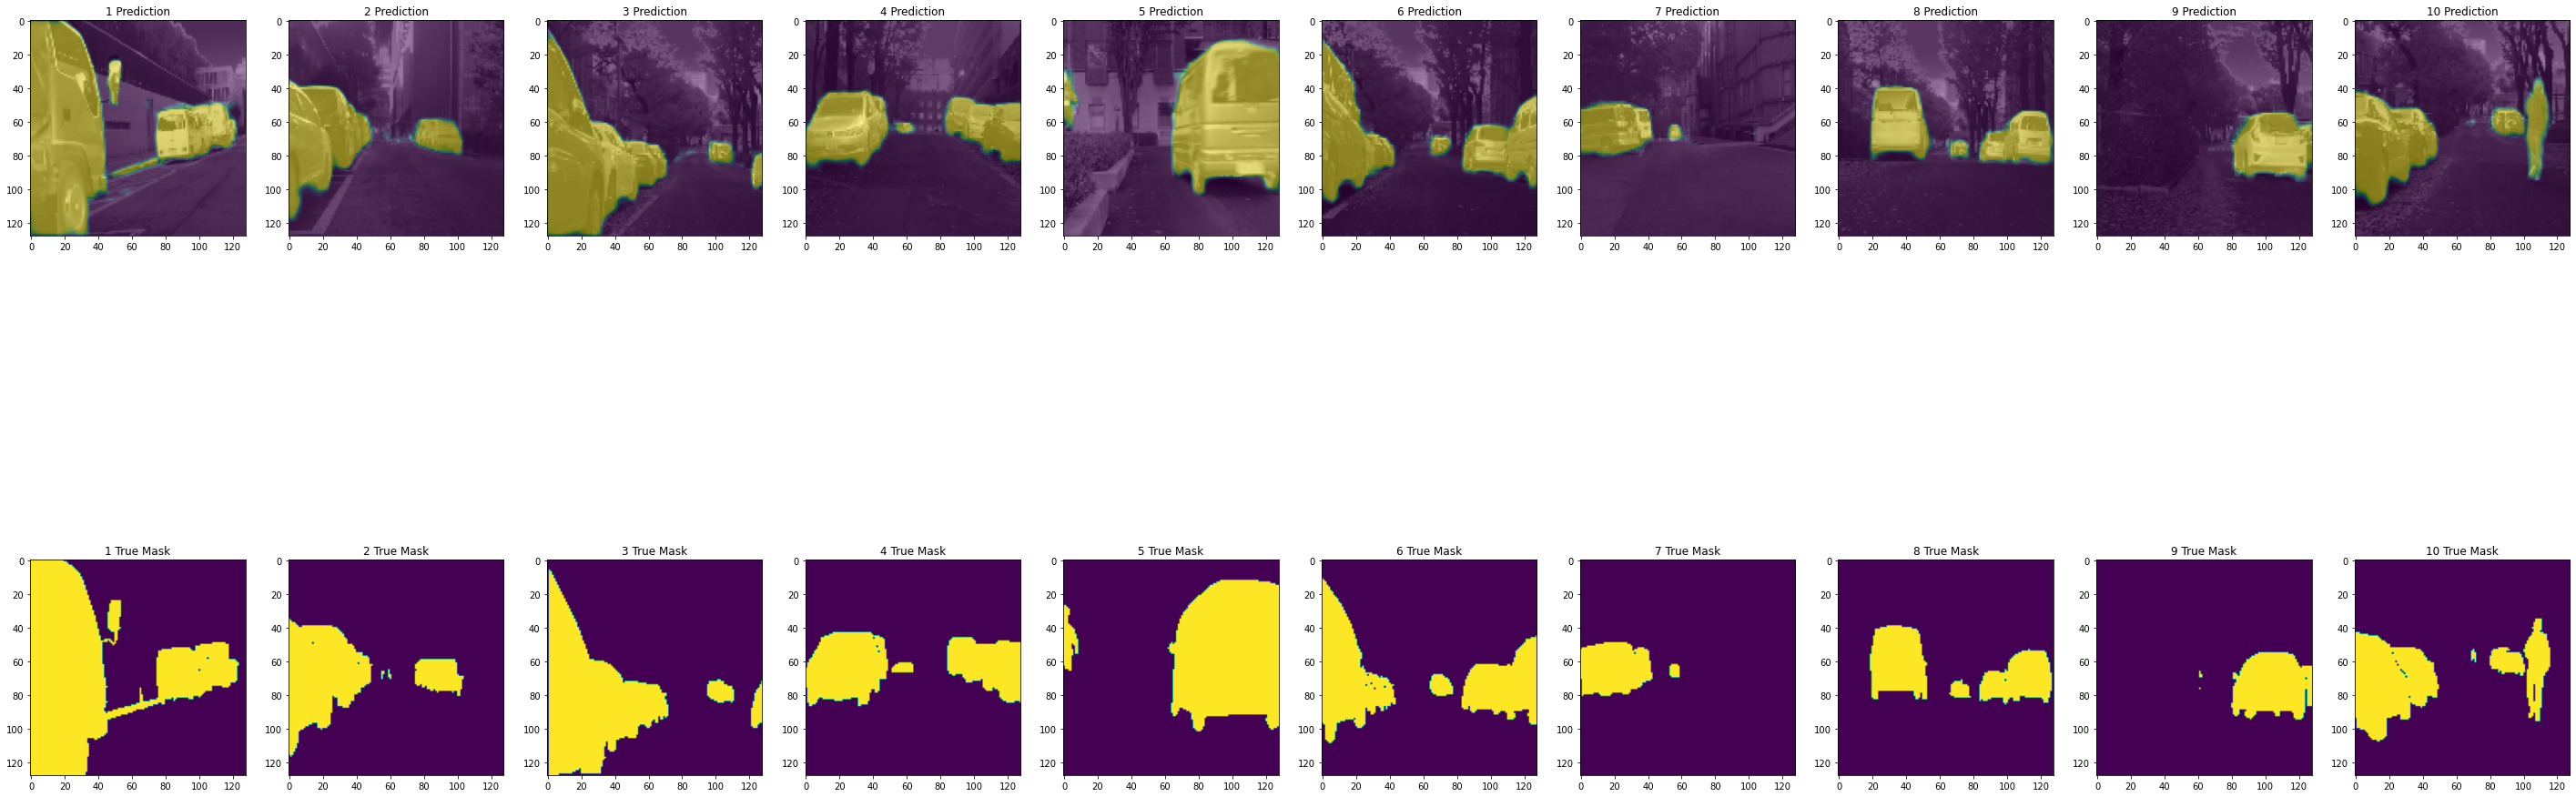

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(50, 20))
for i in range(0,10):
    axs[0,i].set_title("{} Prediction".format(i+1))
    axs[0,i].imshow(np.sum(dc_scores.iloc[-(i+1)]['true_img'], axis=-1), cmap=plt.cm.gray)
    im = axs[0,i].imshow(np.sum(dc_scores.iloc[-(i+1)]['pred_mask'], axis=-1), alpha=0.5, vmin=0, vmax=1)

    axs[1,i].set_title("{} True Mask".format(i+1))
    im = axs[1,i].imshow(np.sum(dc_scores.iloc[-(i+1)]['true_mask'], axis=-1))
    # plt.colorbar(im, ax=axs[0])


# axs[0].set_title("Trained model")
# axs[0].imshow(x_test[i][:,:,0], cmap=plt.cm.gray)
# im = axs[0].imshow(avg_img, alpha=0.5, vmin=0, vmax=1)
# plt.colorbar(im, ax=axs[0])

# true_mask=np.sum(y_test[i:j][0], axis=2)
# axs[1].set_title("True Mask")
# axs[1].imshow(x_test[i][:,:,0], cmap=plt.cm.gray)
# im = axs[1].imshow(true_mask, alpha=0.5, vmin=0, vmax=1)
# plt.colorbar(im, ax=axs[1])

# axs[2].set_title("True Img")
# axs[2].imshow(x_test[i][:,:,0], cmap=plt.cm.gray)
# im = axs[2].imshow(x_test[i:j][0][:,:,1])
# plt.colorbar(im, ax=axs[2])

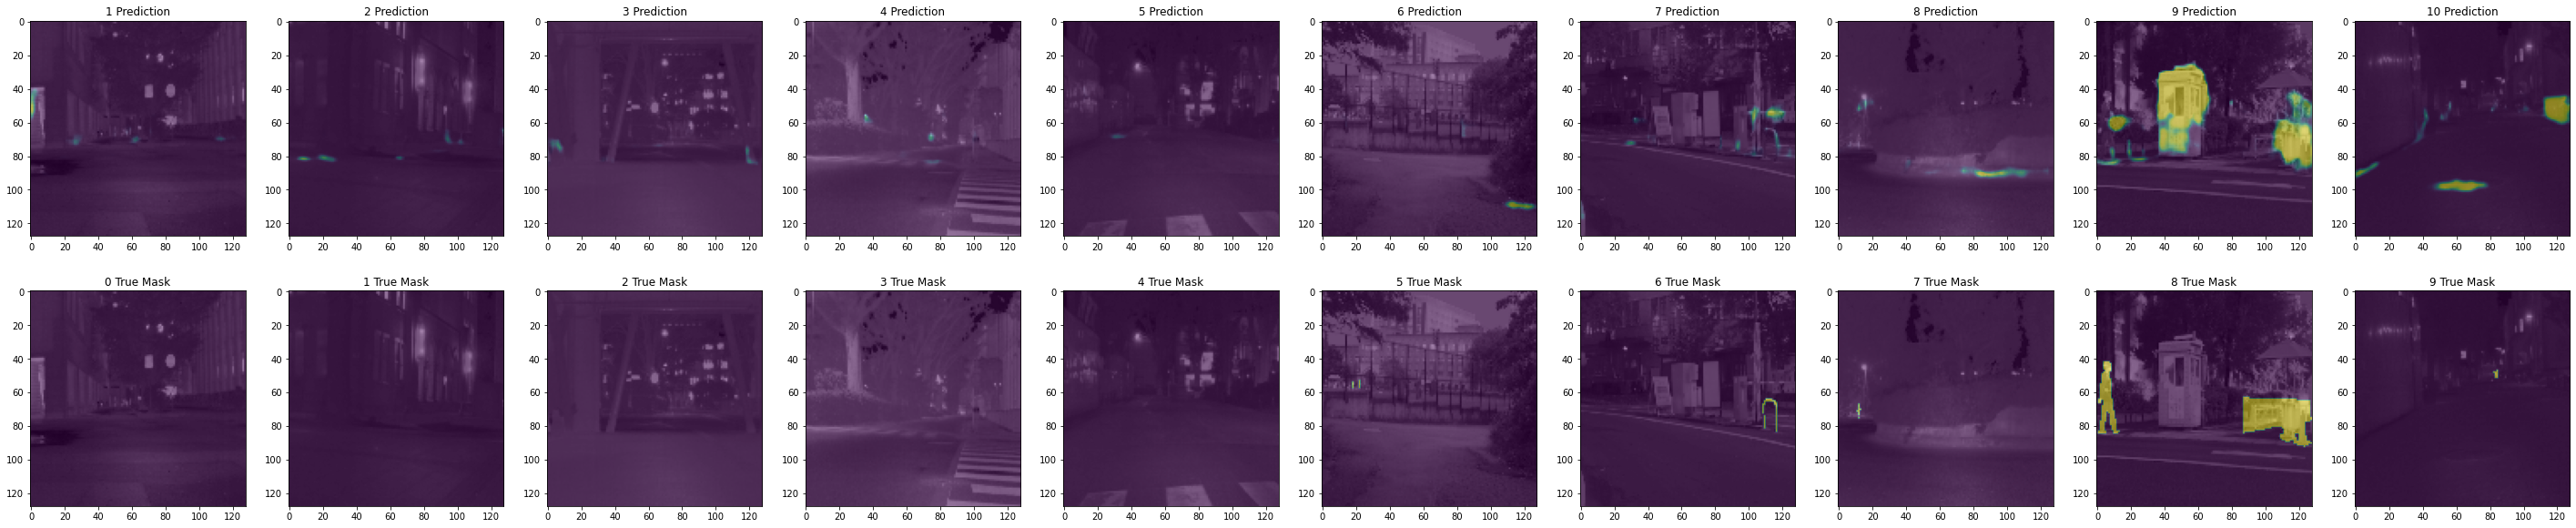

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(50, 10))
for i in range(0,10):
    axs[0,i].set_title("{} Prediction".format(i+1))
    axs[0,i].imshow(np.sum(dc_scores.iloc[i]['true_img'], axis=-1), cmap=plt.cm.gray)
    im = axs[0,i].imshow(np.sum(dc_scores.iloc[i]['pred_mask'], axis=-1), alpha=0.5, vmin=0, vmax=1)

    axs[1,i].set_title("{} True Mask".format(i))
    axs[1,i].imshow(np.sum(dc_scores.iloc[i]['true_img'], axis=-1), cmap=plt.cm.gray)
    im = axs[1,i].imshow(np.sum(dc_scores.iloc[i]['true_mask'], axis=-1),alpha=0.5, vmin=0, vmax=1)

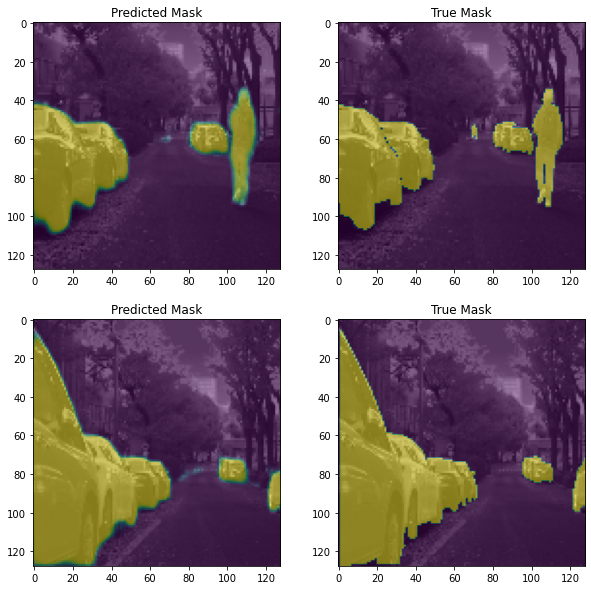

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
# axs[0,0].set_title("Input Image".format(i+1))
# axs[0,0].imshow(np.sum(dc_scores.iloc[-4]['true_img'], axis=-1), cmap=plt.cm.gray)
# # im = axs[0,3].imshow(np.sum(dc_scores.iloc[-8]['pred_mask'], axis=-1), alpha=0.5, vmin=0, vmax=1)


axs[0,0].set_title("Predicted Mask")
axs[0,0].imshow(np.sum(dc_scores.iloc[-10]['true_img'], axis=-1), cmap=plt.cm.gray)
im = axs[0,0].imshow(np.sum(dc_scores.iloc[-10]['pred_mask'], axis=-1), alpha=0.5, vmin=0, vmax=1)

axs[0,1].set_title("True Mask")
axs[0,1].imshow(np.sum(dc_scores.iloc[-10]['true_img'], axis=-1), cmap=plt.cm.gray)
im = axs[0,1].imshow(np.sum(dc_scores.iloc[-10]['true_mask'], axis=-1), alpha=0.5, vmin=0, vmax=1)

axs[1,0].set_title("Predicted Mask")
axs[1,0].imshow(np.sum(dc_scores.iloc[-3]['true_img'], axis=-1), cmap=plt.cm.gray)
im = axs[1,0].imshow(np.sum(dc_scores.iloc[-3]['pred_mask'], axis=-1), alpha=0.5, vmin=0, vmax=1)

axs[1,1].set_title("True Mask")
axs[1,1].imshow(np.sum(dc_scores.iloc[-3]['true_img'], axis=-1), cmap=plt.cm.gray)
im = axs[1,1].imshow(np.sum(dc_scores.iloc[-3]['true_mask'], axis=-1), alpha=0.5, vmin=0, vmax=1)